In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch

sys.path.append("..") # go to parent dir

pd.set_option("display.precision", 0)


def load_result(filepath):
    with open(filepath, 'rb') as handle:
        results = pickle.load(handle)
    return results


def normalize_matrix(A, axis=None):
    Z = np.sum(A, axis=axis, keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A / Z


def log_gaussian(z, params, data, ins, d=59, device="cpu", m_sample=None, n_sample=None):
        """
        Returns the density of the model data given the current parameters; internal method
        :param params: set of model parameters
        :param m_sample: current sample of m_i, only applicable for perso_io=True
        :param n_sample: current sample of r_i, only applicable for perso=True
        :return: log likelihood at each time point for each possible cluster component, k x n x t
        """
        #unpack params
        mu = params['mu']
        var = params['var']

        log_norm_constant = d * torch.log(2 * torch.tensor(math.pi, device=device))

        r = data[None, :, :, :] - mu[:, None, None, :]
        V = params['V']
        r = r - V[:, None, None, :] * ins[None, :, :, None]

        
        r = r**2
        log_p = -0.5 * (var.log()[:, None, None, :] + r / var[:, None, None, :])
        log_p = log_p + log_norm_constant

        log_p = log_p.sum(-1)

        return log_p
    

def calculate_bic(LL, N, k):
    return -2 * LL + np.log(N) * k


def calculate_aic(LL, k):
    return -2 * LL + 2 * k


def calculate_LL_icl(params, Z_train, X_train, D_trian, OM_train, device="cpu"):    
    pi = params["pi"].detach().numpy()
    A = params["A"].detach().numpy()
        
    log_likelihoods = log_gaussian(Z_train, params, X_train, D_train)
    log_likelihoods = (log_likelihoods * OM_train[None, :, :]).to(device)
    
    N, T = Z_train.shape
    
    LL_icl = 0.0
    for i in range(N):
        z = Z_train[i]

        LL_icl += np.log(pi[z[0]])
        LL_icl += sum([np.log(A[z[t-1], z[t]]) for t in range(1, T)])
        LL_icl += sum([log_likelihoods[z[t], i, t] for t in range(T)]) 

    return LL_icl.detach().numpy()


def calculate_icl(LL, N, k):
    return -2 * LL + np.log(N) * k


def plot_vector(pi, title, figsize=(8, 2), normalize=False, vmax=1.0, vmin=0.0):
    if normalize:
        A = normalize_matrix(pi, axis=1)
    else:
        A = pi
    k = pi.shape[0]
    
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    im = ax.imshow(pi, cmap=plt.cm.gray_r, vmax=vmax, vmin=vmin, aspect="auto")
    fig.colorbar(im, ax=ax)
    labels = ['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7', 'State 8']
    
    plt.xticks(list(range(len(labels))), labels, fontsize=12, rotation=90)
    filepath = '../outputs/' + title + ".png"
    fig.savefig(filepath, dpi=400, bbox_inches="tight")
    
def plot_matrix(x, title, normalize=False, vmax=1.0, vmin=0.0):
    if normalize:
        A = normalize_matrix(x, axis=1)
    else:
        A = x
        
    k = A.shape[0]
    fig = plt.figure()
    ax = fig.gca()
    im = ax.imshow(A, cmap=plt.cm.gray_r, vmax=vmax, vmin=vmin, aspect="auto")
    fig.colorbar(im, ax=ax)
    plt.xlabel("next state", fontsize=24)
    plt.ylabel("current state", fontsize=24)
    labels = ['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7', 'State 8']
    
    plt.xticks(list(range(len(labels))), labels, fontsize=12, rotation=90)
    plt.yticks(list(range(len(labels))), labels, fontsize=12)
    filepath = '../outputs/' + title + ".png"
    fig.savefig(filepath, dpi=400, bbox_inches="tight")


def preprocess(x, d):
    # don't include samples which only have one measurement, i.e. aren't time series
    remove_idx = np.where(np.sum(~np.isnan(x[:,:,0]), axis=1) == 1)
    x = np.delete(x, remove_idx, 0)
    d = np.delete(d, remove_idx, 0)
    # set any LEDD values greater than 5000 to 620 and rescale
    d[d > 5000] = 620
    d[np.isnan(d)] =  0
    d = d/np.max(d)
    # get time and observation masks
    N, T, D, = x.shape
    time_mask = np.ones((N, T))
    for i in range(N):
        ind = np.where(~np.isnan(x[i, :, 0]))[0][-1] + 1
        time_mask[i, ind:] = 0
    missing_mask = (~np.isnan(x[:, :, 0])).astype(float)
    x[np.isnan(x)] = 0
    # convert everything to tensors
    X = torch.Tensor(x).float()
    D = torch.Tensor(d).float()
    TM = torch.Tensor(time_mask).float()
    OM = torch.Tensor(missing_mask).bool()
    return X, D, TM, OM

### data and model imports

In [2]:
import pickle
from src.piomhmm import mHMM
from src.utils import load_pickle

data = load_pickle('../data/processed/data_for_PIOHMM.pkl')

X_train, D_train, TM_train, OM_train = preprocess(data['x_train'], data['train_med'])  

# these are the models reported in the paper
mIOHMM_PPMI_tests = {K: load_result('../models/April09/mIOHMM_' + str(K) +'.pkl') for K in range(1, 6)}

## these are the models that can be exactly reproduced as we now save the random seeds used. 
## these results are different than those in the paper as different seeds are used; 
## however, the trend is similar in that the same mixtures are favoured.
# mIOHMM_PPMI_tests = {K: load_result('../models/August17/mIOHMM_' + str(K) +'.pkl') for K in range(1, 6)}

### model selection via information criteria 

In [3]:
model_metrics = {}
N = mIOHMM_PPMI_tests[1]["e_out"]["gamma"].shape[1] # 332
T = mIOHMM_PPMI_tests[1]["e_out"]["gamma"].shape[2] # 37
d = mIOHMM_PPMI_tests[1]["params"]["mu"].shape[1] # 59
for K, mIOHMM_PPMI_test in mIOHMM_PPMI_tests.items(): 
    
    LL = mIOHMM_PPMI_test["ll"][-1]
    k = mIOHMM_PPMI_test["params"]["pi"].shape[0]
    k = (k-1) + (k * (k-1)) + (k*d) + (k*d) + (k*d)
    
    model = mHMM(X_train, ins=D_train, k=8, K=K, TM=TM_train, OM=OM_train, full_cov=False, io=True, 
                 personalized=False, personalized_io=False, state_io=True, UT=True, device="cpu", eps=1e-18)

    params = mIOHMM_PPMI_test["params"]
    Z_train = model.predict_sequence(params).detach().numpy().astype(int)
    LL_icl = calculate_LL_icl(params, Z_train, X_train, D_train, OM_train)
    model_metrics[K] = [LL, LL_icl, calculate_aic(LL, k), calculate_bic(LL, N, k), calculate_icl(LL_icl, N, k)]
    
df = pd.DataFrame(model_metrics, index=["LL", "LL-ICL", "AIC", "BIC", "ICL"])  
display(df)

,1,2,3,4,5
LL,2768659,27768922,27774591,27790277,27776619
LL-ICL,27132072.82956439,27673815.17239621,27636920.968697503,26136626.578256477,27650025.602670386
AIC,-55370221,-5553167,-55539536,-55567181,-5553588
BIC,-55364593,-55519923,-55521184,-55541736,-55502855
ICL,-5425556,-5532971,-55245844,-52234434,-55249668


### cluster properties
#### number of samples in each cluster

In [4]:
from collections import Counter


k = 8
K = 2
model = mHMM(X_train, ins=D_train, k=k, K=K, TM=TM_train, OM=OM_train, full_cov=False, io=True, 
             personalized=False, personalized_io=False, state_io=True, UT=True, device="cpu", eps=1e-18)
params = mIOHMM_PPMI_tests[K]["params"]
model_mps = model.predict_sequence(params).detach().numpy().astype(int)
N = model_mps.shape[0]

# sequences in each cluster
cluster_labels = []
for i in range(N):
    unq_vals = np.unique(model_mps[i])
    
    j = 0
    while all([val in range(j*k, (j+1)*k) for val in unq_vals]) is False:
        j += 1
        
    cluster_labels.append(j)
    
print(Counter(cluster_labels))    

Counter({1: 227, 0: 105})


#### average medication data in clusters

In [5]:
# avg medication in each cluster
cluster_meds = {i:[] for i in range(K)}
for i, label in enumerate(cluster_labels):
    cluster_meds[label].append(D_train.mean(axis=1)[i])
    
for label in cluster_meds:
    print(label, np.mean(cluster_meds[label]))    

0 0.059825476
1 0.05821191


#### the distribution of sex and age

In [6]:
train_patno = data["train_patno"]
x = data['x_train']
remove_idx = np.where(np.sum(~np.isnan(x[:,:,0]), axis=1) == 1)
train_patno_left = np.delete(train_patno, remove_idx, 0)

demo = pd.read_csv('../../Discovery-of-PD-States-using-ML/demographics.csv', index_col=0)
demo["ENROLLDT"] = pd.to_datetime(demo["ENROLLDT"])
demo["BIRTHDT"] = pd.to_datetime(demo["BIRTHDT"])
demo["AGE"] = (demo["ENROLLDT"] - demo["BIRTHDT"]) / np.timedelta64(1, 'Y')

K = 2
cluster_genders = {i:[] for i in range(K)}
cluster_ages = {i:[] for i in range(K)}

for i, label in enumerate(cluster_labels):
    
    patno = train_patno_left[i]
    gender = demo.loc[demo['PATNO'] == patno].iloc[0]["GENDER"]
    age = demo.loc[demo['PATNO'] == patno].iloc[0]["AGE"]
    
    cluster_genders[label].append(gender)
    cluster_ages[label].append(age)

for label in cluster_genders:
    vals = cluster_genders[label]
    ages = cluster_ages[label]
    print(label, Counter(vals), np.mean(ages), np.std(ages))
# 1 male
# 0 female

0 Counter({2.0: 76, 1.0: 29}) 60.57561887291451 10.057697767029767
1 Counter({2.0: 141, 1.0: 86}) 62.08989326655494 9.61891151421709


In [7]:
# sex ratio
76/(76+29), 141/(141+86)

(0.7238095238095238, 0.6211453744493393)

In [8]:
# mean and std of age
np.hstack([cluster_ages[label] for label in cluster_ages]).mean(), np.hstack([cluster_ages[label] for label in cluster_ages]).std()

(61.6109811842289, 9.785186949137277)

### transition dynamics

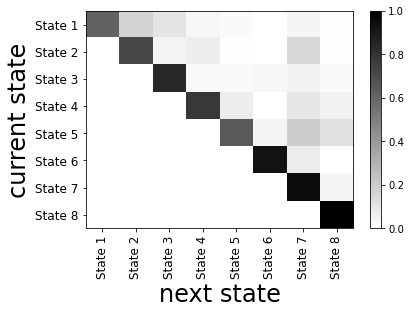

In [9]:
K = 1
A = mIOHMM_PPMI_tests[K]["params"]["A"].detach().numpy()    
for k in range(K):    
    plot_matrix(A[k*8:(k+1)*8, k*8:(k+1)*8], title="mIOHMM-"+str(K)+"-A-"+str(k+1), normalize=True)

### state means

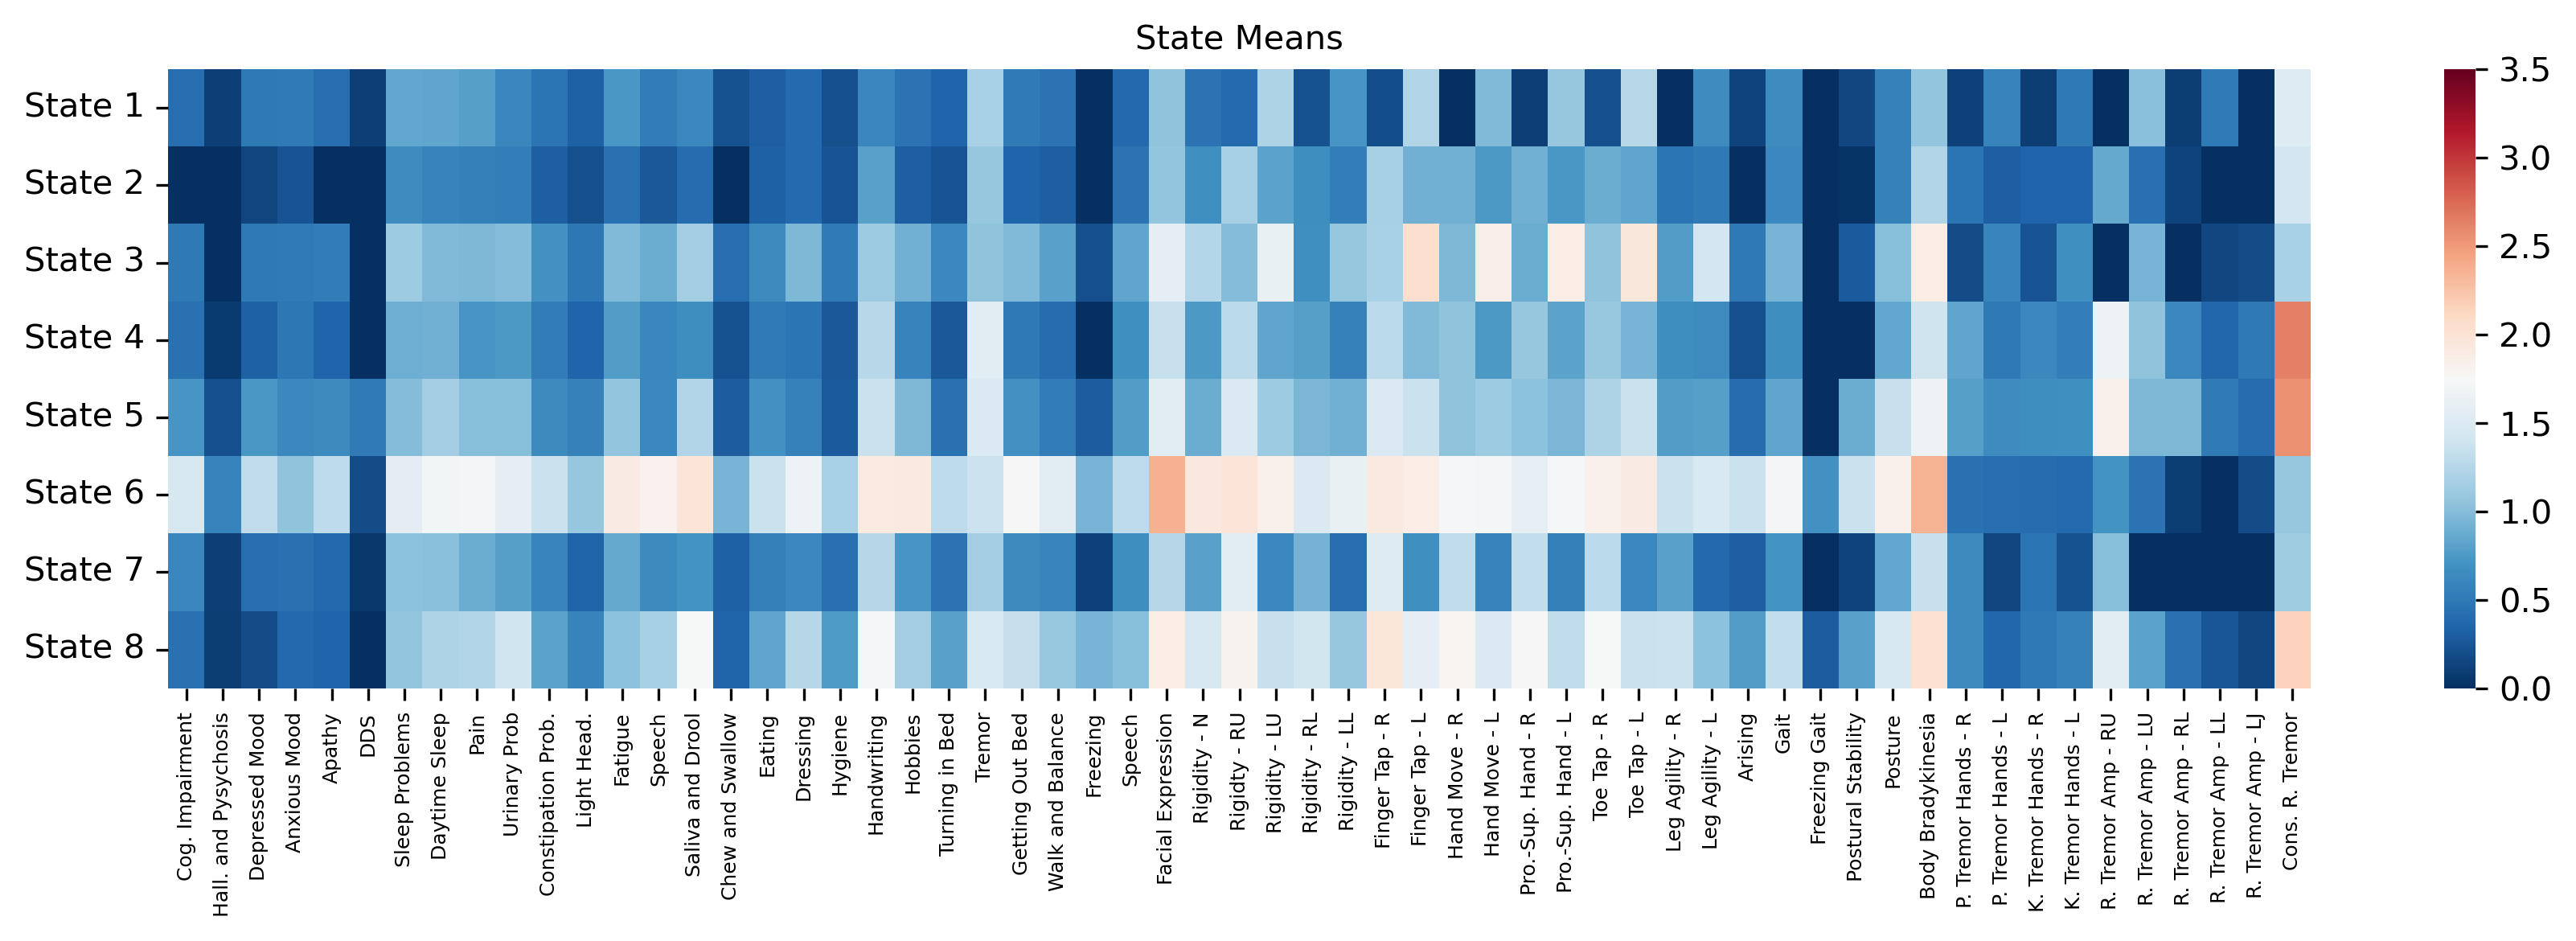

In [10]:
from collections import OrderedDict
import seaborn as sns


titles = OrderedDict({
    "NP1COG": "Cog. Impairment", "NP1HALL": "Hall. and Pysychosis", "NP1DPRS": "Depressed Mood",
    "NP1ANXS": "Anxious Mood", "NP1APAT": "Apathy", "NP1DDS": "DDS", "NP1SLPN": "Sleep Problems",
    "NP1SLPD": "Daytime Sleep", "NP1PAIN": "Pain", "NP1URIN": "Urinary Prob", "NP1CNST": "Constipation Prob.",
    "NP1LTHD": "Light Head.", "NP1FATG": "Fatigue", "NP2SPCH":"Speech", "NP2SALV":"Saliva and Drool",
    "NP2SWAL":"Chew and Swallow", "NP2EAT":"Eating", "NP2DRES":"Dressing", "NP2HYGN":"Hygiene",
    "NP2HWRT":"Handwriting", "NP2HOBB":"Hobbies", "NP2TURN":"Turning in Bed", "NP2TRMR":"Tremor", 
    "NP2RISE":"Getting Out Bed", "NP2WALK":"Walk and Balance", "NP2FREZ":"Freezing", "NP3SPCH":"Speech", 
    "NP3FACXP":"Facial Expression", "NP3RIGN":"Rigidity - N", "NP3RIGRU":"Rigidty - RU",
    "NP3RIGLU":"Rigidity - LU", "PN3RIGRL": "Rigidity - RL", "NP3RIGLL":"Rigidity - LL",    
    "NP3FTAPR":"Finger Tap - R", "NP3FTAPL": "Finger Tap - L", "NP3HMOVR":"Hand Move - R", 
    "NP3HMOVL":"Hand Move - L", "NP3PRSPR":"Pro.-Sup. Hand - R", "NP3PRSPL":"Pro.-Sup. Hand - L",
    "NP3TTAPR":"Toe Tap - R", "NP3TTAPL":"Toe Tap - L", "NP3LGAGR":"Leg Agility - R", 
    "NP3LGAGL":"Leg Agility - L", "NP3RISNG":"Arising", "NP3GAIT":"Gait", "NP3FRZGT":"Freezing Gait", 
    "NP3PSTBL":"Postural Stability", "NP3POSTR":"Posture", "NP3BRADY":"Body Bradykinesia", 
    "NP3PTRMR":"P. Tremor Hands - R", "NP3PTRML":"P. Tremor Hands - L", "NP3KTRMR":"K. Tremor Hands - R", 
    "NP3KTRML":"K. Tremor Hands - L", "NP3RTARU":"R. Tremor Amp - RU", "NP3RTALU":"R. Tremor Amp - LU", 
    "NP3RTARL":"R. Tremor Amp - RL", "NP3RTALL":"R. Tremor Amp - LL", "NP3RTALJ":"R. Tremor Amp - LJ", 
    "NP3RTCON":"Cons. R. Tremor"
})

cols = titles.values()

K = 1
mu = mIOHMM_PPMI_tests[K]["params"]["mu"].detach().numpy()

fig, axs = plt.subplots(K,1,dpi=300)
fig.set_size_inches(12,4*K)

for i in range(K):
    if K == 1:
        ax = axs
    else:
        ax = axs[i]
    sns.heatmap(mu[i*8:(i+1)*8,:], cmap='RdBu_r',ax=ax, vmax=3.5)

    ax.set_xticks(np.arange(0.5,59.5))
    ax.set_xticklabels(cols,rotation=90,fontsize=6)
    ax.set_yticks(np.arange(0.5,8,1))
    ax.set_yticklabels(['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7', 'State 8'],rotation=360,fontsize=10)
    ax.set_title('State Means', fontsize=10)

    cbar = ax.collections[0].colorbar
#     cbar.set_ticks([-0.1,3])
#     cbar.set_ticklabels(['Less\nSevere', 'More\nSevere'])
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
# fig.savefig('figure2b.eps', format='eps', dpi=300)

### state means summary

- State 1 is the most frequent state at enrollment and has the lowest total MDS-UPDRS score. State 0 has no patients on medication. 
- States 2 and 4 both have moderate tremor and are primarily differentiated by which side of the body the disease
affects. 
- State 6 has high tremor. 
- States 3, 5, and 7 have increasingly severe gait issues.

Per the subtype methodology of Stebbins et al. (2013), which uses MDS-UPDRS subitems
to assign patients who are not on medication to tremor or PI/G subtypes, 
- state 5 is PI/G dominant, 
- states 0-4 and 6 are tremor dominant, and 
- state 7 is indeterminate.

0


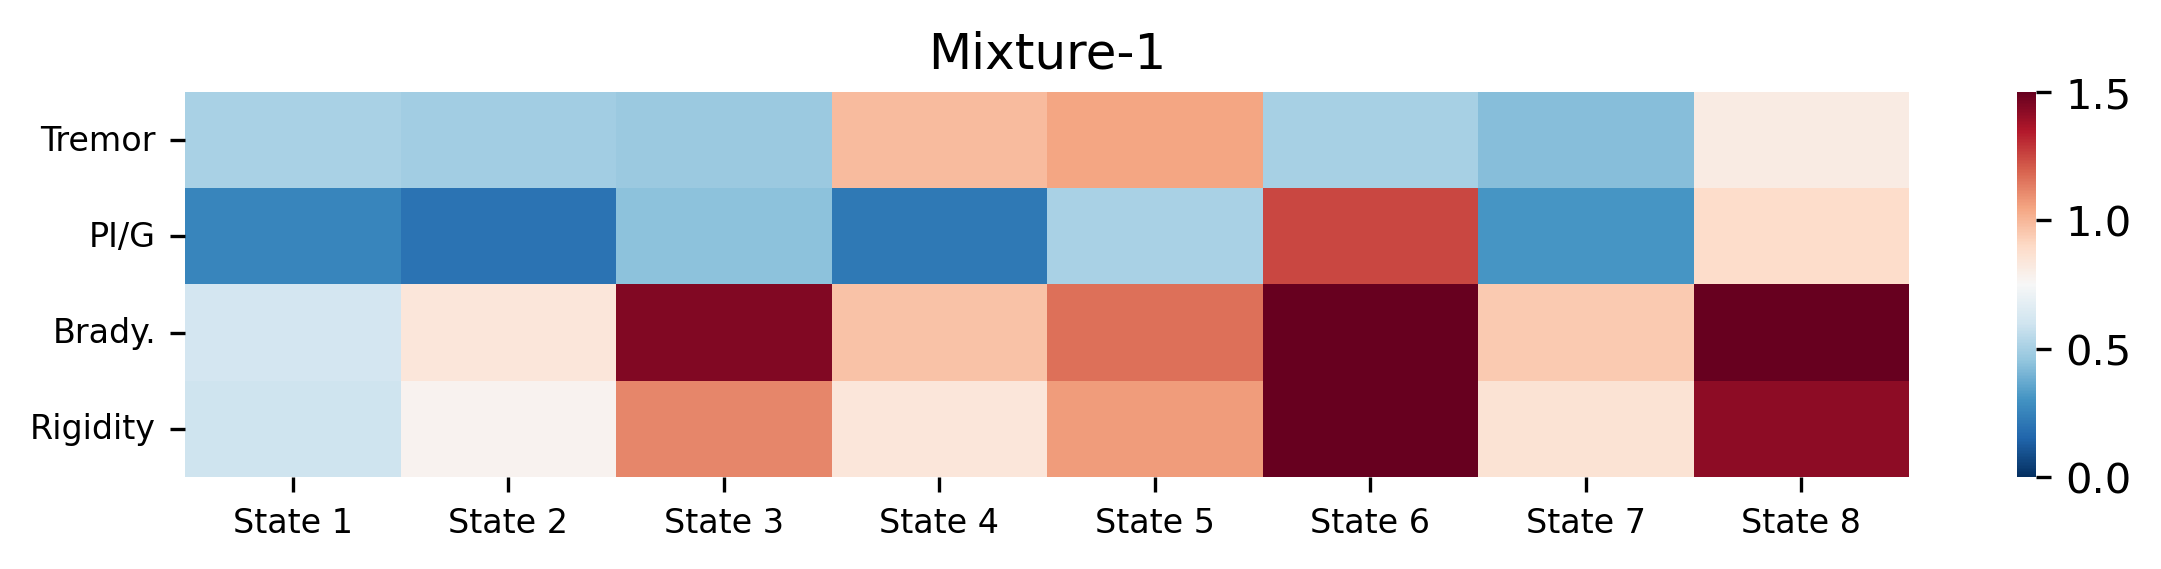

In [11]:
np.set_printoptions(precision=2)

K = 1
mu = mIOHMM_PPMI_tests[K]["params"]["mu"].detach().numpy()

mu_summary = np.zeros((K, 4, 8))
for i in range(K):
    print(i)
    mu_i = mu[i*8:(i+1)*8]
    
    tremor_cols = ["NP2TRMR", "NP3PTRMR", "NP3PTRML", "NP3KTRMR", "NP3KTRML", "NP3RTARU", "NP3RTALU", "NP3RTARL", 
                   "NP3RTALL", "NP3RTALJ", "NP3RTCON"]
    tremor_ind = [list(titles.keys()).index(col) for col in tremor_cols]    
    mu_summary[i,0,:] = mu_i[:,tremor_ind].mean(axis=1)
    
    pig_cols = ["NP2WALK", "NP2FREZ", "NP3GAIT", "NP3FRZGT", "NP3PSTBL"]
    pig_ind = [list(titles.keys()).index(col) for col in pig_cols]    
    mu_summary[i,1,:] = mu_i[:,pig_ind].mean(axis=1)

    bra_cols = ["NP3FTAPR", "NP3FTAPL", "NP3HMOVR", "NP3HMOVL", "NP3PRSPR", "NP3PRSPL", "NP3TTAPR",
               "NP3TTAPL", "NP3LGAGR", "NP3LGAGL", "NP3BRADY"]
    bra_ind = [list(titles.keys()).index(col) for col in bra_cols]
    mu_summary[i,2,:] = mu_i[:,bra_ind].mean(axis=1)

    rig_cols = ["NP3RIGN", "NP3RIGRU", "NP3RIGLU", "PN3RIGRL", "NP3RIGLL"]
    rig_ind = [list(titles.keys()).index(col) for col in rig_cols]
    mu_summary[i,3,:] = mu_i[:,rig_ind].mean(axis=1)
    
fig, axs = plt.subplots(K,1,dpi=300)
fig.set_size_inches(8,2*K)
rows = ["Tremor", "PI/G", "Brady.", "Rigidity"] 
cols = ['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7', 'State 8']

for i in range(K):
    if K == 1:
        ax = axs
    else:
        ax = axs[i]
    sns.heatmap(mu_summary[i], cmap='RdBu_r',ax=ax, vmin=0.0, vmax=1.5)

    ax.set_xticks(np.arange(0.5,8.5))
    ax.set_xticklabels(cols, rotation=0,fontsize=8)
    ax.set_yticks(np.arange(0.5,4,1))
    ax.set_yticklabels(rows, rotation=360, fontsize=8)
    cbar = ax.collections[0].colorbar
#     cbar.set_ticks([0, 3])
#     cbar.set_ticklabels(['Less\nSevere', 'More\nSevere'])
    ax.set_title("Mixture-"+str(i+1))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
# fig.savefig('figure2b.eps', format='eps', dpi=300)

In [12]:
mu_summary[0,0]/mu_summary[0,1]

array([2.  , 2.51, 1.06, 4.62, 2.07, 0.4 , 1.39, 0.91])

0
1


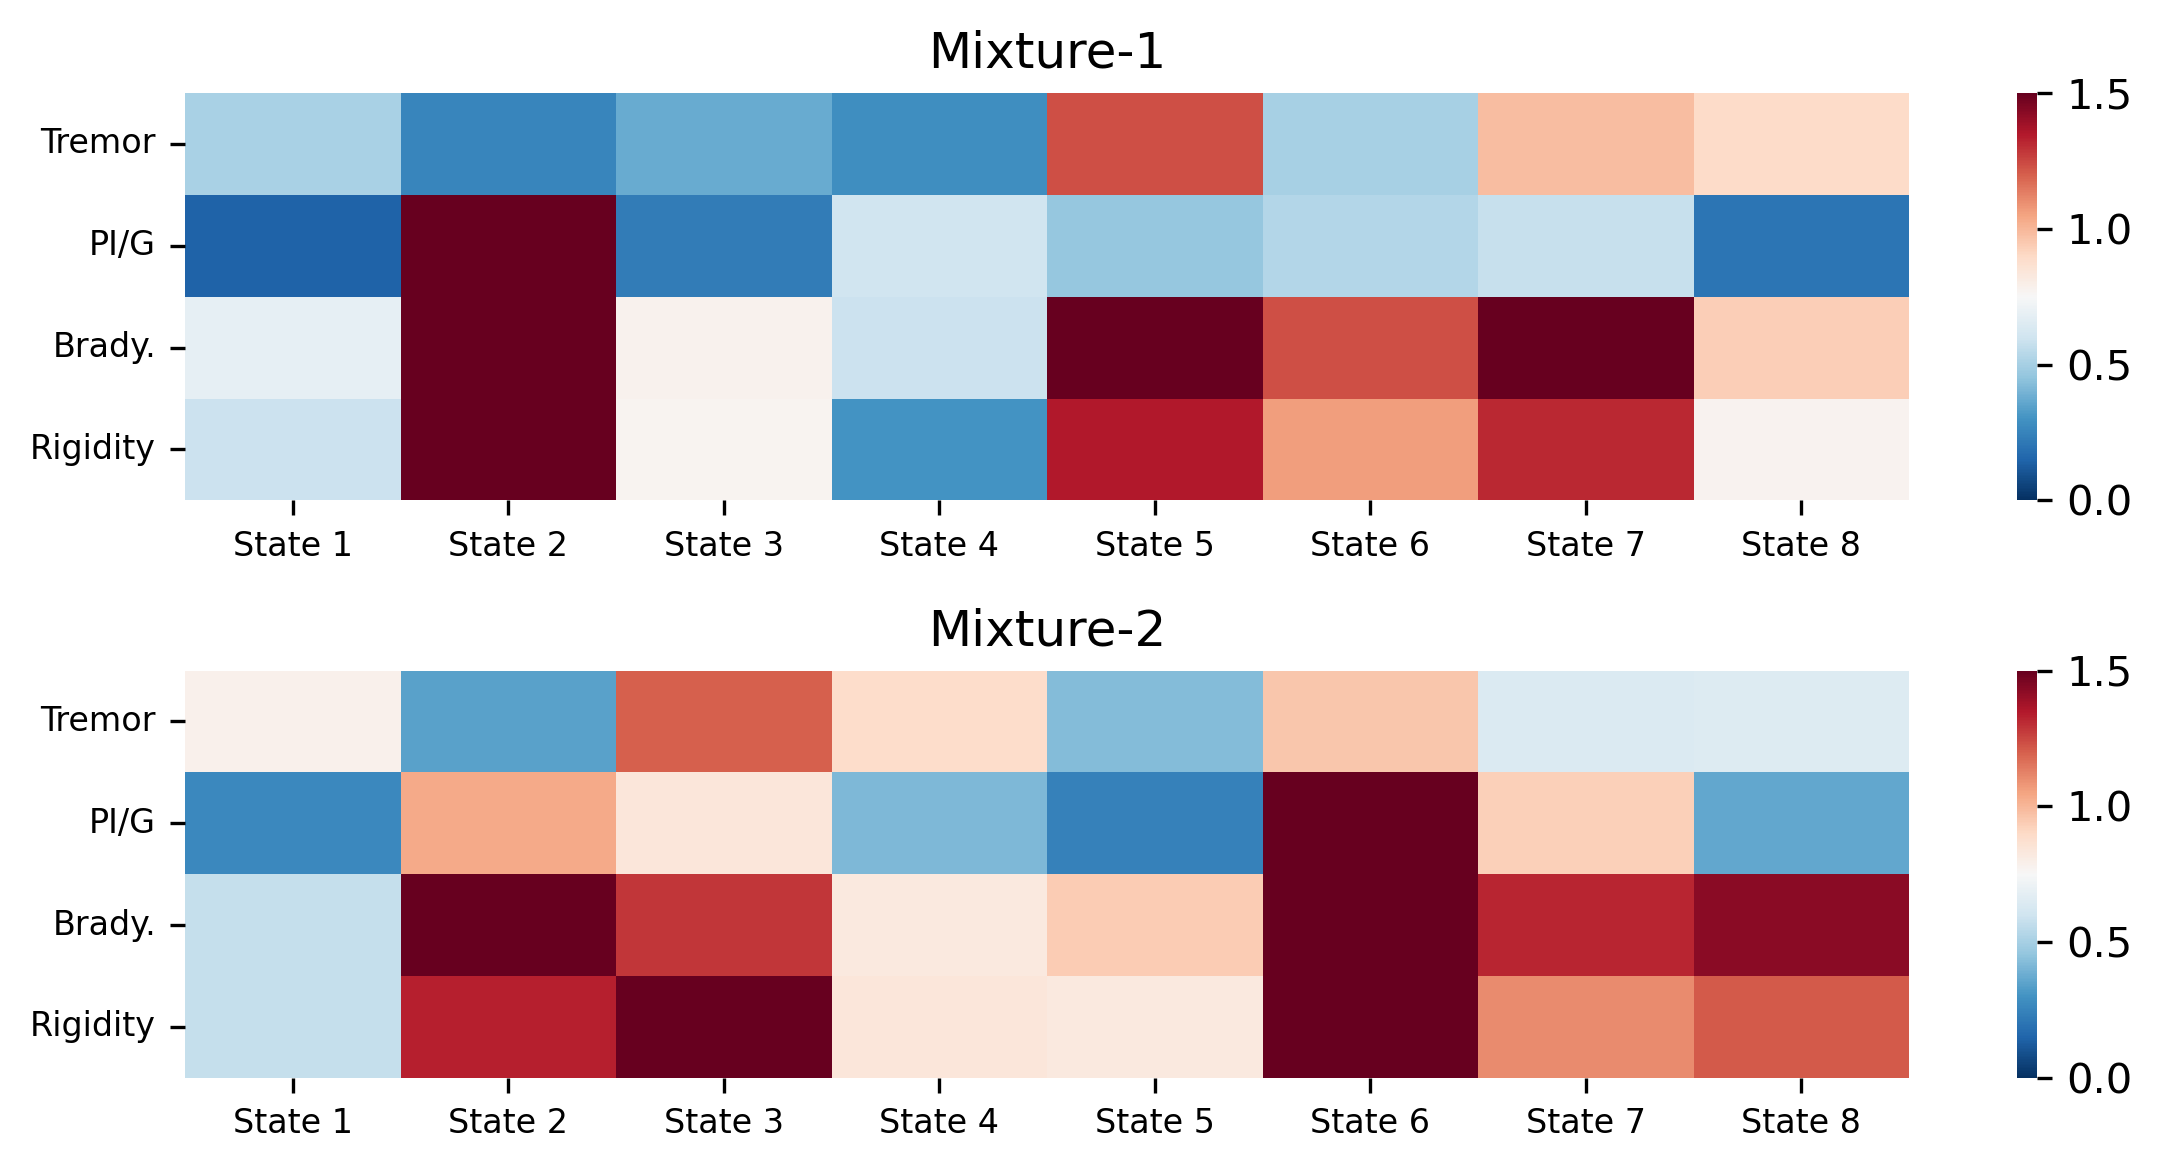

In [13]:
np.set_printoptions(precision=2)

K = 2
mu = mIOHMM_PPMI_tests[K]["params"]["mu"].detach().numpy()

mu_summary = np.zeros((K, 4, 8))
for i in range(K):
    print(i)
    mu_i = mu[i*8:(i+1)*8]
    
    tremor_cols = ["NP2TRMR", "NP3PTRMR", "NP3PTRML", "NP3KTRMR", "NP3KTRML", "NP3RTARU", "NP3RTALU", "NP3RTARL", "NP3RTALL", 
    "NP3RTALJ", "NP3RTCON"]
    tremor_ind = [list(titles.keys()).index(col) for col in tremor_cols]    
    mu_summary[i,0,:] = mu_i[:,tremor_ind].mean(axis=1)
    
    pig_cols = ["NP2WALK", "NP2FREZ", "NP3GAIT", "NP3FRZGT", "NP3PSTBL"]
    pig_ind = [list(titles.keys()).index(col) for col in pig_cols]    
    mu_summary[i,1,:] = mu_i[:,pig_ind].mean(axis=1)

    bra_cols = ["NP3FTAPR", "NP3FTAPL", "NP3HMOVR", "NP3HMOVL", "NP3PRSPR", "NP3PRSPL", "NP3TTAPR",
               "NP3TTAPL", "NP3LGAGR", "NP3LGAGL", "NP3BRADY"]
    bra_ind = [list(titles.keys()).index(col) for col in bra_cols]
    mu_summary[i,2,:] = mu_i[:,bra_ind].mean(axis=1)

    rig_cols = ["NP3RIGN", "NP3RIGRU", "NP3RIGLU", "PN3RIGRL", "NP3RIGLL"]
    rig_ind = [list(titles.keys()).index(col) for col in rig_cols]
    mu_summary[i,3,:] = mu_i[:,rig_ind].mean(axis=1)
    
fig, axs = plt.subplots(K,1,dpi=300)
fig.set_size_inches(8,4)
rows = ["Tremor", "PI/G", "Brady.", "Rigidity"] 
cols = ['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7', 'State 8']
for i in range(K):
    ax = axs[i]
    sns.heatmap(mu_summary[i], cmap='RdBu_r',ax=ax, vmin=0.0, vmax=1.5)

    ax.set_xticks(np.arange(0.5,8.5))
    ax.set_xticklabels(cols, rotation=0,fontsize=8)
    ax.set_yticks(np.arange(0.5,4,1))
    ax.set_yticklabels(rows, rotation=360, fontsize=8)
    cbar = ax.collections[0].colorbar
#     cbar.set_ticks([0, 3])
#     cbar.set_ticklabels(['Less\nSevere', 'More\nSevere'])
    ax.set_title("Mixture-"+str(i+1))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
# fig.savefig('figure2b.eps', format='eps', dpi=300)

In [14]:
for i in range(K):
    print(i, mu_summary[i,0]/mu_summary[i,1])

0 [3.54 0.1  1.63 0.47 2.66 0.95 1.7  4.46]
1 [2.94 0.33 1.42 2.15 1.77 0.61 0.69 1.79]


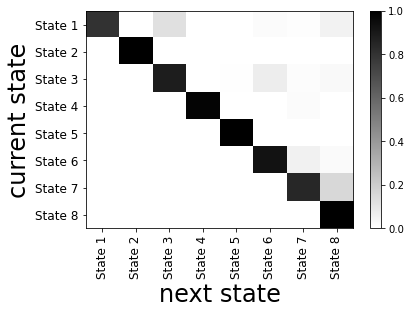

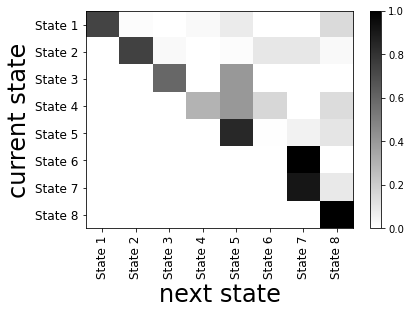

In [15]:
K = 2
A = mIOHMM_PPMI_tests[K]["params"]["A"].detach().numpy()    
for k in range(K):    
    plot_matrix(A[k*8:(k+1)*8, k*8:(k+1)*8], title="mIOHMM-"+str(K)+"-A-"+str(k+1), normalize=True)

### initial states

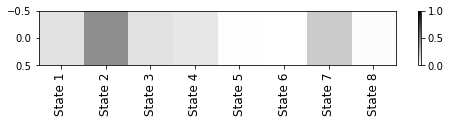

In [16]:
K = 1
pi = mIOHMM_PPMI_tests[K]["params"]["pi"].detach().numpy()    
for k in range(K):    
    plot_vector(pi[k*8:(k+1)*8].reshape(1,8), figsize=(8,1), title="mIOHMM-"+str(K)+"-pi-"+str(k+1), normalize=True)

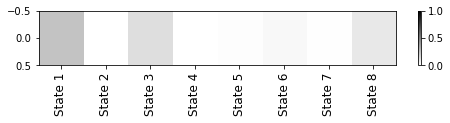

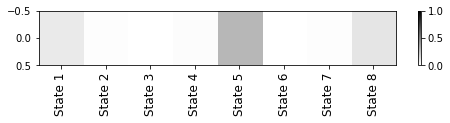

In [17]:
K = 2
pi = mIOHMM_PPMI_tests[K]["params"]["pi"].detach().numpy()    
for k in range(K):    
    plot_vector(pi[k*8:(k+1)*8].reshape(1,8), figsize=(8,1), title="mIOHMM-"+str(K)+"-pi-"+str(k+1), normalize=True)

- State 1 and State 5 are the most frequent states at enrollment for the 1st and 2nd mixtures.

- "States 2 and 4 both
have moderate tremor and are primarily differentiated by which side of the body the disease
affects. "

- State 5 and 3 have high tremor.
- States 1 and 6 have severe gait issues


    

### medication variables

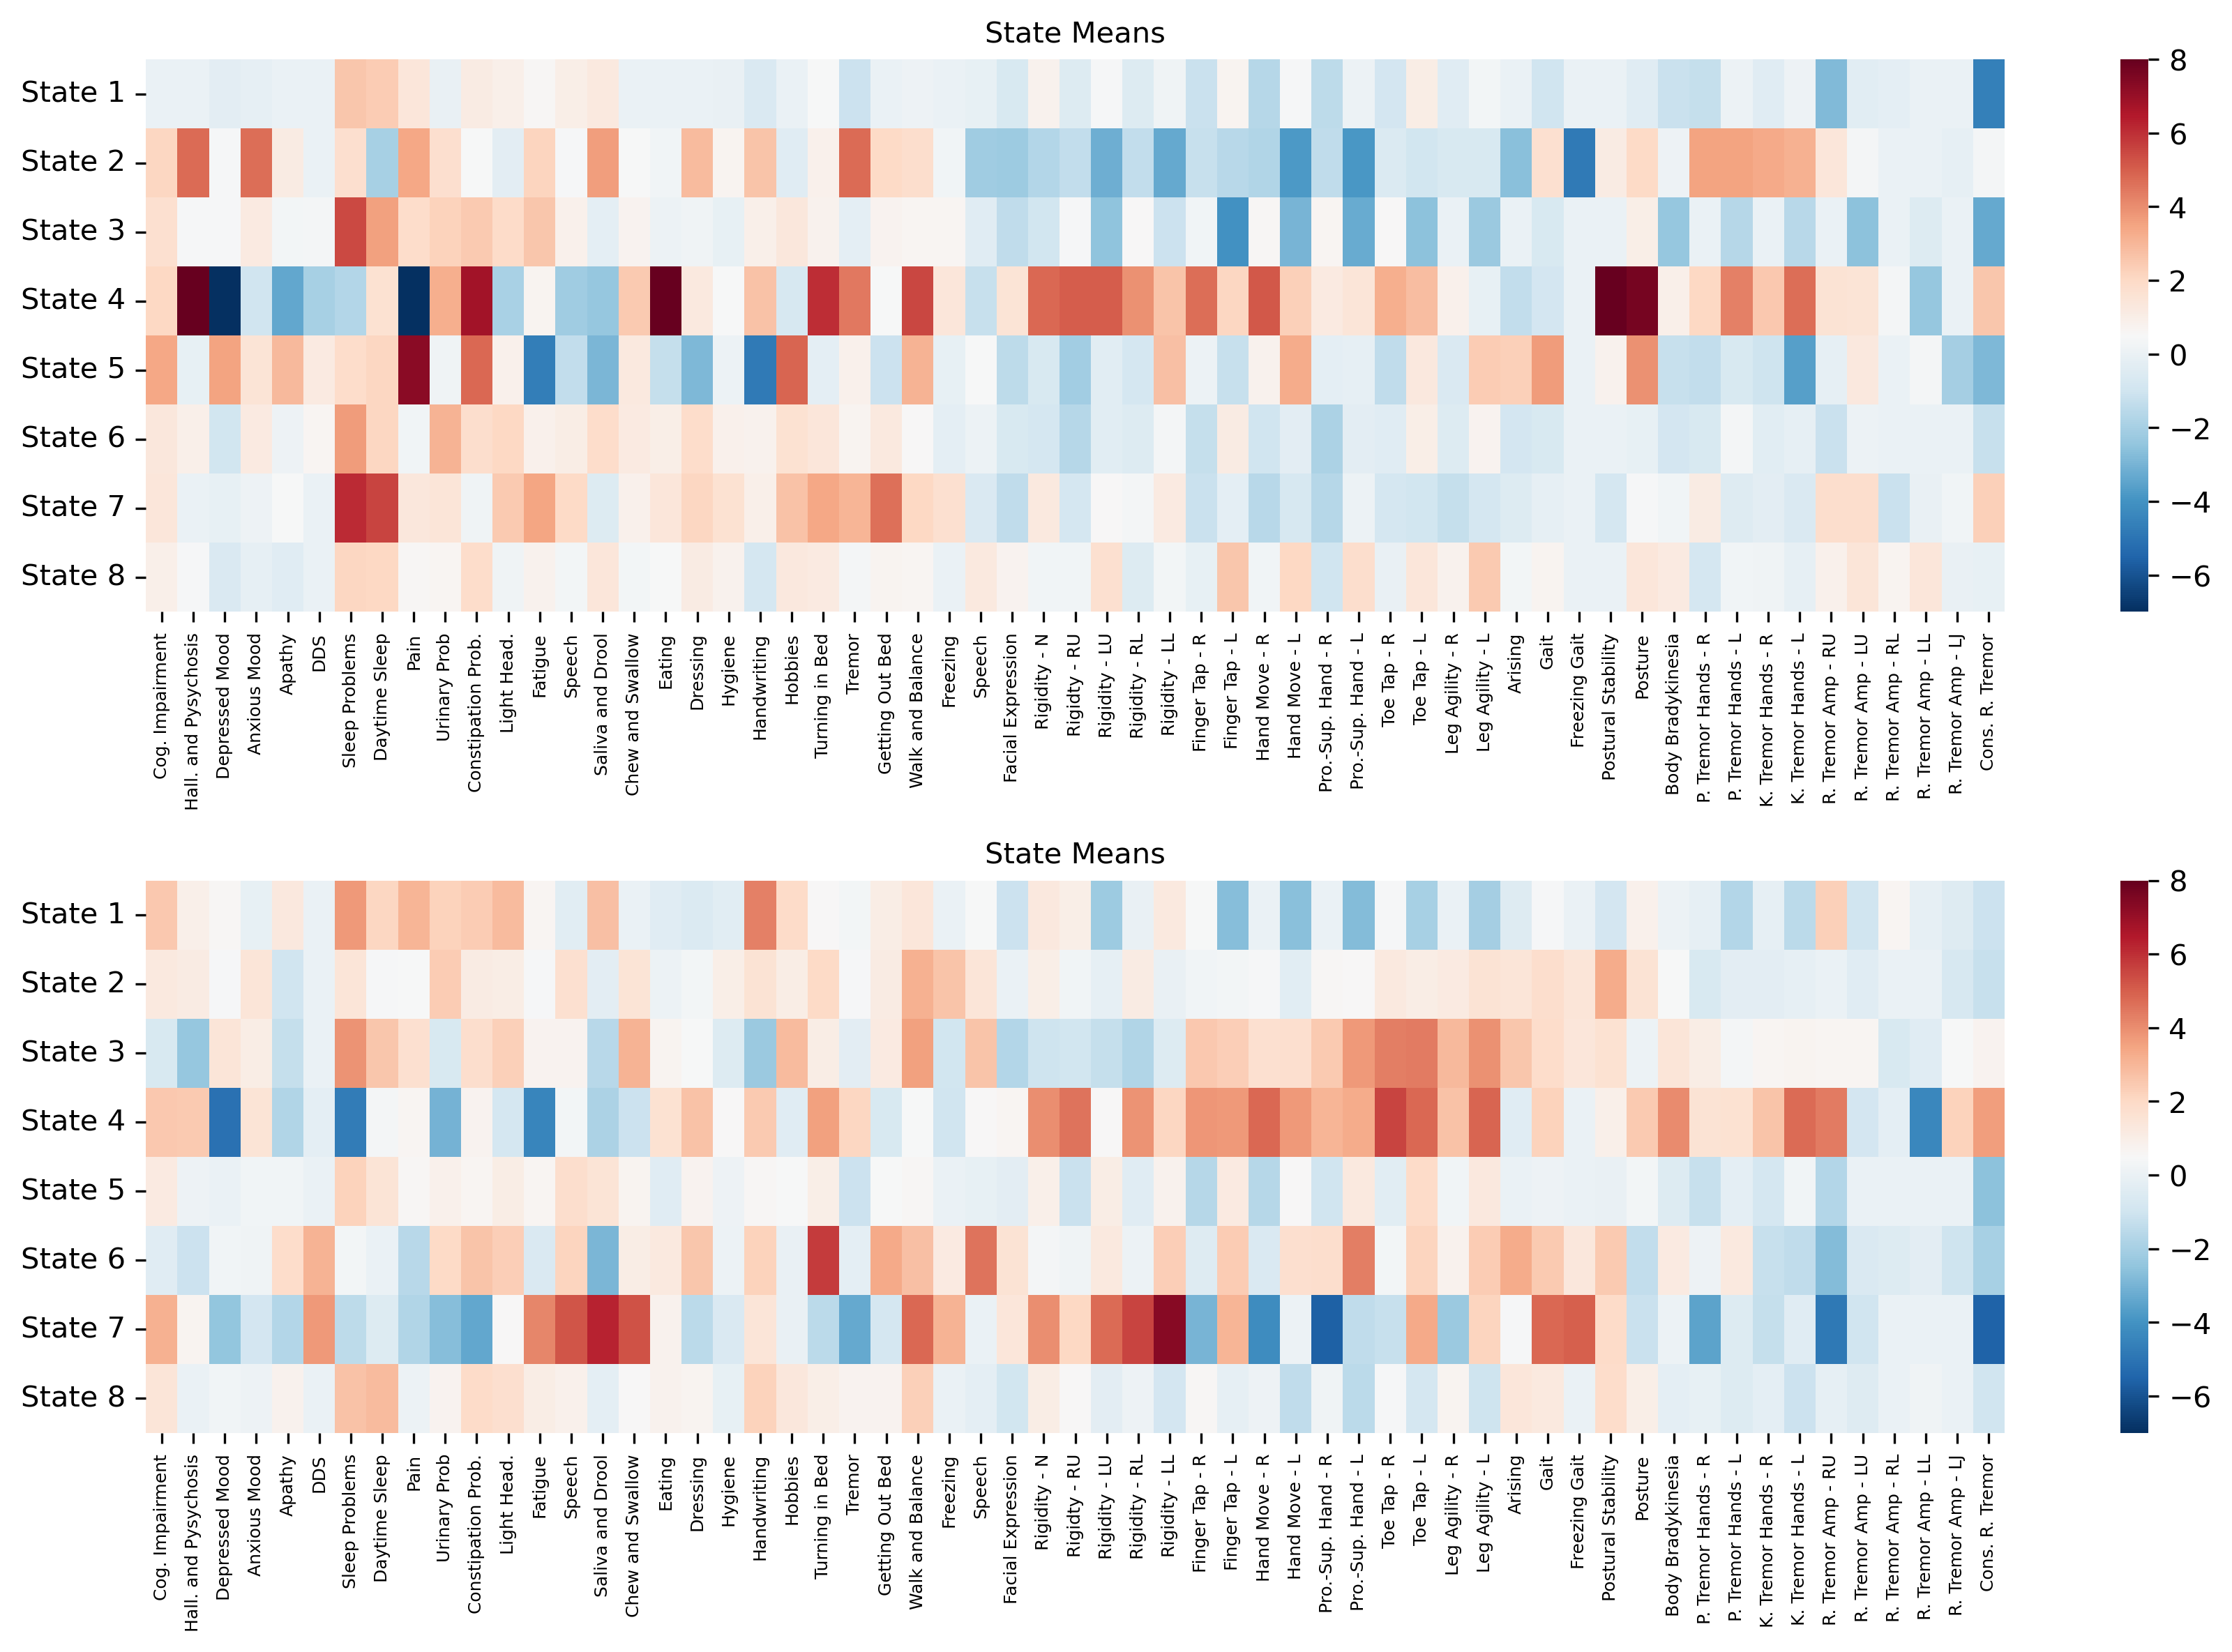

In [18]:
titles = OrderedDict({
    "NP1COG": "Cog. Impairment", "NP1HALL": "Hall. and Pysychosis", "NP1DPRS": "Depressed Mood",
    "NP1ANXS": "Anxious Mood", "NP1APAT": "Apathy", "NP1DDS": "DDS", "NP1SLPN": "Sleep Problems",
    "NP1SLPD": "Daytime Sleep", "NP1PAIN": "Pain", "NP1URIN": "Urinary Prob", "NP1CNST": "Constipation Prob.",
    "NP1LTHD": "Light Head.", "NP1FATG": "Fatigue", "NP2SPCH":"Speech", "NP2SALV":"Saliva and Drool",
    "NP2SWAL":"Chew and Swallow", "NP2EAT":"Eating", "NP2DRES":"Dressing", "NP2HYGN":"Hygiene",
    "NP2HWRT":"Handwriting", "NP2HOBB":"Hobbies", "NP2TURN":"Turning in Bed", "NP2TRMR":"Tremor", 
    "NP2RISE":"Getting Out Bed", "NP2WALK":"Walk and Balance", "NP2FREZ":"Freezing", "NP3SPCH":"Speech", 
    "NP3FACXP":"Facial Expression", "NP3RIGN":"Rigidity - N", "NP3RIGRU":"Rigidty - RU",
    "NP3RIGLU":"Rigidity - LU", "PN3RIGRL": "Rigidity - RL", "NP3RIGLL":"Rigidity - LL",    
    "NP3FTAPR":"Finger Tap - R", "NP3FTAPL": "Finger Tap - L", "NP3HMOVR":"Hand Move - R", 
    "NP3HMOVL":"Hand Move - L", "NP3PRSPR":"Pro.-Sup. Hand - R", "NP3PRSPL":"Pro.-Sup. Hand - L",
    "NP3TTAPR":"Toe Tap - R", "NP3TTAPL":"Toe Tap - L", "NP3LGAGR":"Leg Agility - R", 
    "NP3LGAGL":"Leg Agility - L", "NP3RISNG":"Arising", "NP3GAIT":"Gait", "NP3FRZGT":"Freezing Gait", 
    "NP3PSTBL":"Postural Stability", "NP3POSTR":"Posture", "NP3BRADY":"Body Bradykinesia", 
    "NP3PTRMR":"P. Tremor Hands - R", "NP3PTRML":"P. Tremor Hands - L", "NP3KTRMR":"K. Tremor Hands - R", 
    "NP3KTRML":"K. Tremor Hands - L", "NP3RTARU":"R. Tremor Amp - RU", "NP3RTALU":"R. Tremor Amp - LU", 
    "NP3RTARL":"R. Tremor Amp - RL", "NP3RTALL":"R. Tremor Amp - LL", "NP3RTALJ":"R. Tremor Amp - LJ", 
    "NP3RTCON":"Cons. R. Tremor"
})

cols = titles.values()

K = 2
V = mIOHMM_PPMI_tests[K]["params"]["V"].detach().numpy()    

fig, axs = plt.subplots(K,1,dpi=300)
fig.set_size_inches(12,8)

for i in range(K):
    ax = axs[i]
    sns.heatmap(V[i*8:(i+1)*8,:], cmap='RdBu_r',ax=ax, vmin=-7.0, vmax=8.0)

    ax.set_xticks(np.arange(0.5,59.5))
    ax.set_xticklabels(cols,rotation=90,fontsize=6)
    ax.set_yticks(np.arange(0.5,8,1))
    ax.set_yticklabels(['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7', 'State 8'],rotation=360,fontsize=10)
    ax.set_title('State Means', fontsize=10)

    cbar = ax.collections[0].colorbar
#     cbar.set_ticks([-0.1,3])
#     cbar.set_ticklabels(['Less\nSevere', 'More\nSevere'])
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
# fig.savefig('figure2b.eps', format='eps', dpi=300)

In [19]:
np.set_printoptions(precision=2)

K = 1
V = mIOHMM_PPMI_tests[K]["params"]["V"].detach().numpy()

V_summary = np.zeros((K, 4, 8))
for i in range(K):
    print(i)
    V_i = V[i*8:(i+1)*8]
    
    tremor_cols = ["NP2TRMR", "NP3PTRMR", "NP3PTRML", "NP3KTRMR", "NP3KTRML", "NP3RTARU", "NP3RTALU", "NP3RTARL", "NP3RTALL", 
    "NP3RTALJ", "NP3RTCON"]
    tremor_ind = [list(titles.keys()).index(col) for col in tremor_cols]    
    V_summary[i,0,:] = V_i[:,tremor_ind].mean(axis=1)
    
    pig_cols = ["NP2WALK", "NP2FREZ", "NP3GAIT", "NP3FRZGT", "NP3PSTBL"]
    pig_ind = [list(titles.keys()).index(col) for col in pig_cols]    
    V_summary[i,1,:] = V_i[:,pig_ind].mean(axis=1)

    bra_cols = ["NP3FTAPR", "NP3FTAPL", "NP3HMOVR", "NP3HMOVL", "NP3PRSPR", "NP3PRSPL", "NP3TTAPR",
               "NP3TTAPL", "NP3LGAGR", "NP3LGAGL", "NP3BRADY"]
    bra_ind = [list(titles.keys()).index(col) for col in bra_cols]
    V_summary[i,2,:] = V_i[:,bra_ind].mean(axis=1)

    rig_cols = ["NP3RIGN", "NP3RIGRU", "NP3RIGLU", "PN3RIGRL", "NP3RIGLL"]
    rig_ind = [list(titles.keys()).index(col) for col in rig_cols]
    V_summary[i,3,:] = V_i[:,rig_ind].mean(axis=1)

0


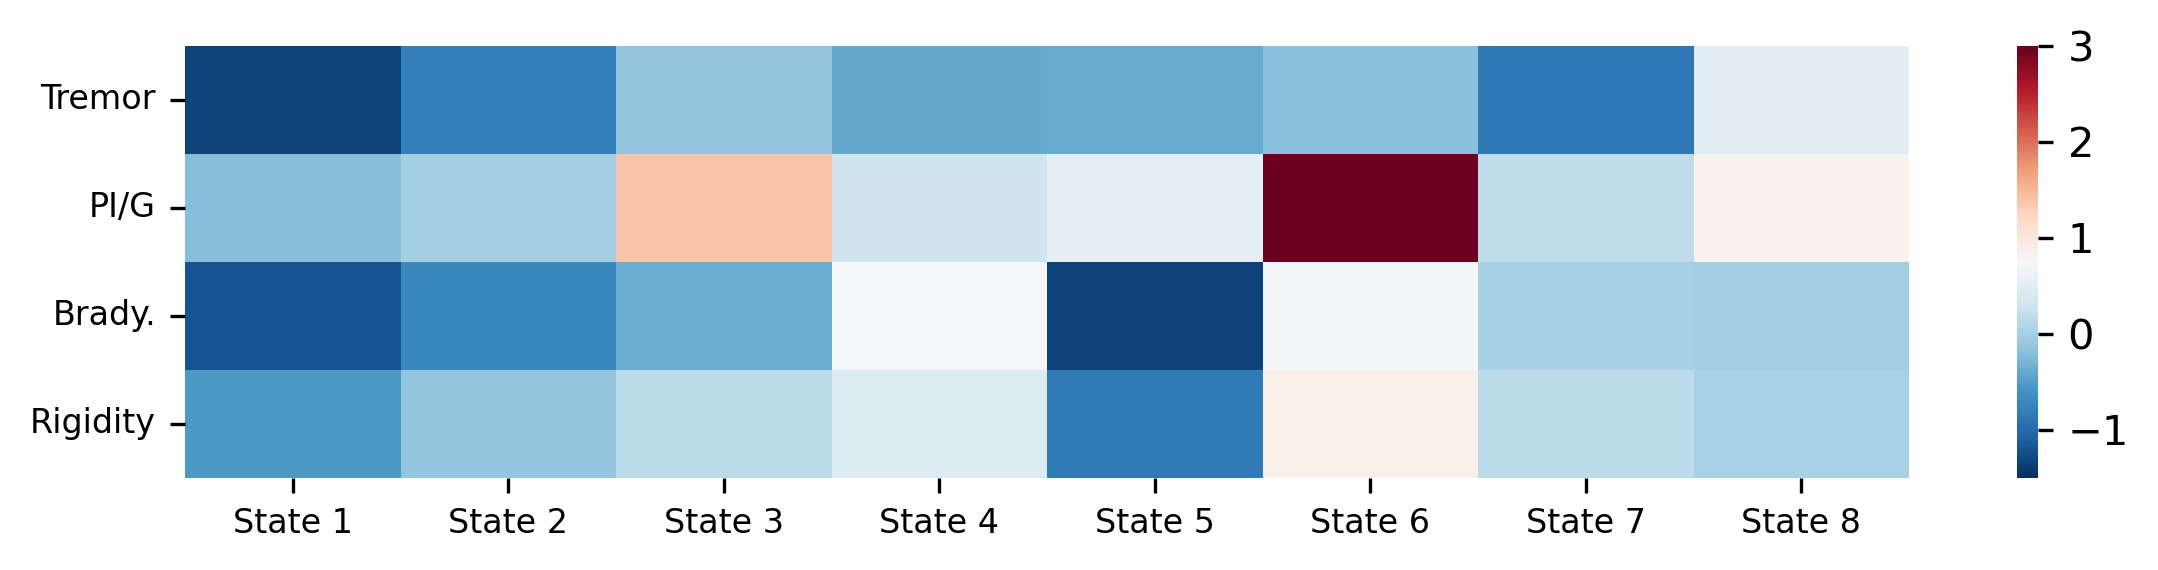

In [20]:
fig, axs = plt.subplots(K,1,dpi=300)
fig.set_size_inches(8,2)
rows = ["Tremor", "PI/G", "Brady.", "Rigidity"] 
cols = ['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7', 'State 8']

for i in range(K):
    ax = axs
    sns.heatmap(V_summary[i], cmap='RdBu_r',ax=ax, vmin=-1.5, vmax=3)

    ax.set_xticks(np.arange(0.5,8.5))
    ax.set_xticklabels(cols, rotation=0,fontsize=8)
    ax.set_yticks(np.arange(0.5,4,1))
    ax.set_yticklabels(rows, rotation=360, fontsize=8)
#     cbar = ax.collections[0].colorbar
#     cbar.set_ticks([0, 3])
#     cbar.set_ticklabels(['Less\nSevere', 'More\nSevere'])
#     if i == 0:
#         title = "1st IOHMM mixture"
#     else:
#         title = "2nd IOHMM mixture"
#     ax.set_title(title)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.savefig('../outputs/v-summary-mIOHMM-1.png', dpi=400, bbox_inches="tight")

### PPMI Log-likelihood Difference

(84,)
(84,)


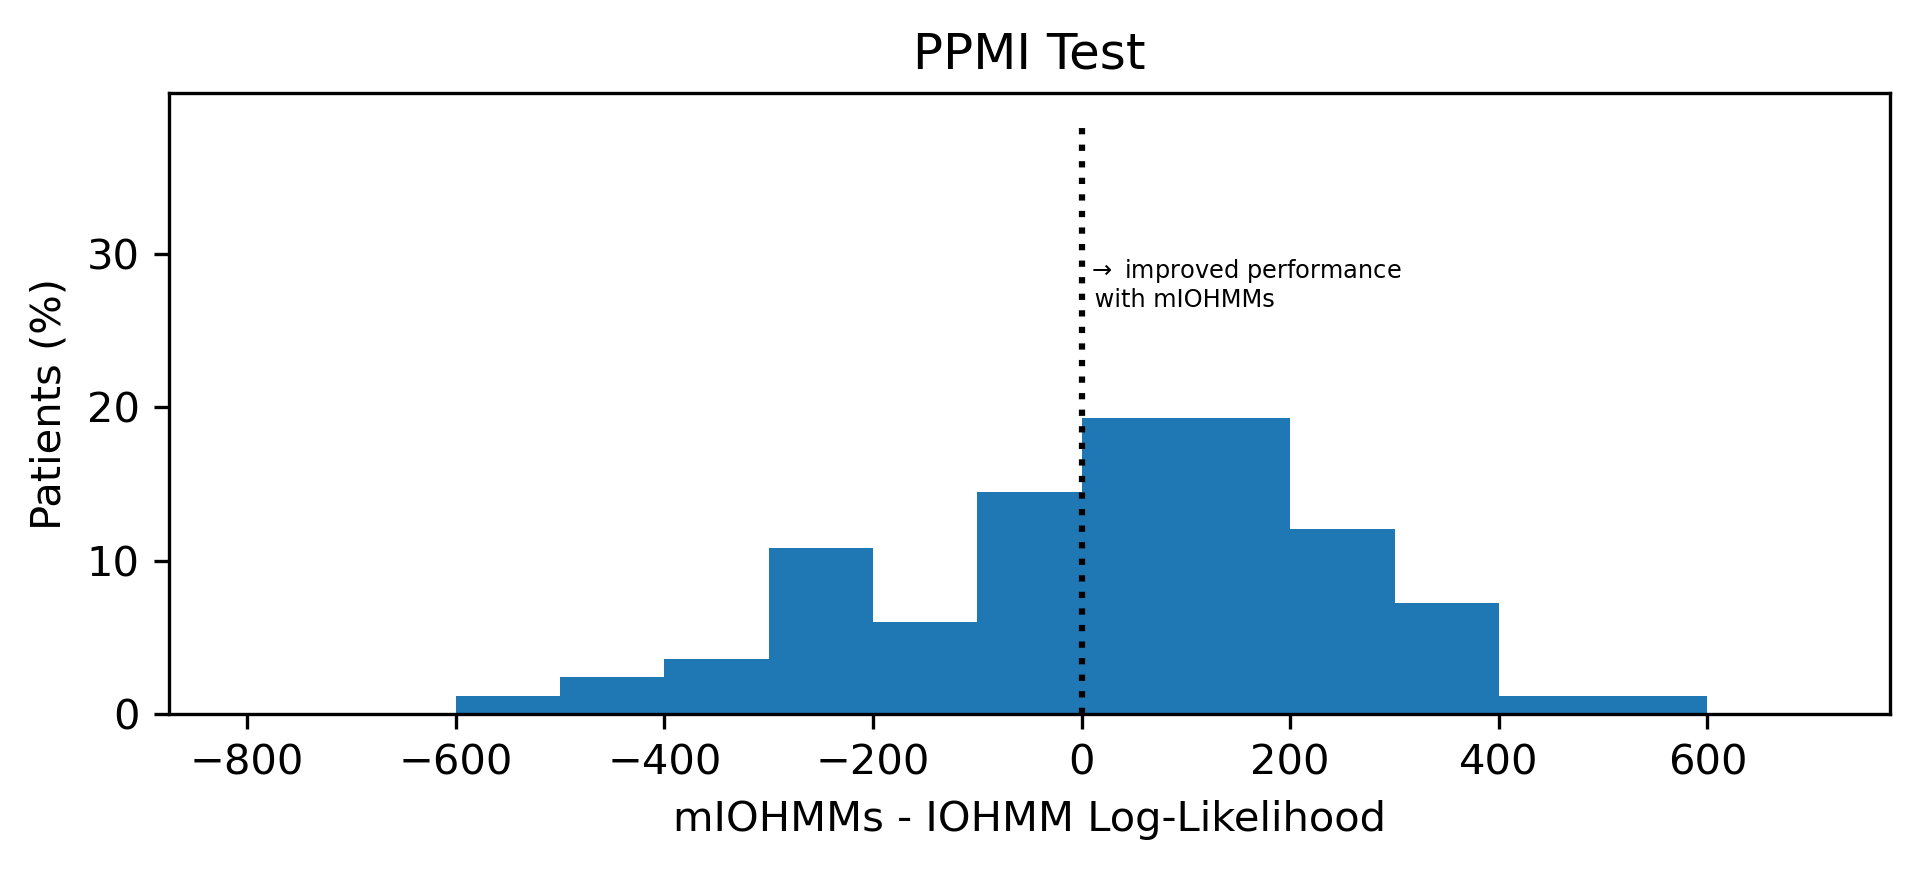

In [21]:
K = 1
x = mIOHMM_PPMI_tests[K]["test_pX"].detach().numpy()
print(x.shape)

K = 2
y = mIOHMM_PPMI_tests[K]["test_pX"].detach().numpy()
print(y.shape)

fig, ax = plt.subplots(1,1,dpi=300)
fig.set_size_inches(6.5, 3)
ax.hist(y-x, bins = np.arange(-800,800,100))
ax.plot(np.zeros(33), np.arange(33),'k:')
ax.set_yticks([0,8.3,16.6,24.9])
ax.set_yticklabels(['0', '10', '20', '30'])
ax.annotate(r"$\rightarrow$ improved performance" +"\n" + " with mIOHMMs", (5,22), fontsize='xx-small')
ax.set_xlabel('mIOHMMs - IOHMM Log-Likelihood')
ax.set_ylabel('Patients (%)')
ax.set_title('PPMI Test')

fig.tight_layout()
plt.show()
fig.savefig('../outputs/ppmi_test.pdf', dpi=100)